Introduction
This project looks to predict individuals health insurance prices based a few factors about said individual. We will look at age, sex, if the person smokes, BMI, number of children, and region to predict the health insurance charge. If we can accurately predict the health insurance price incurred by the individual, we can help companies figure out what to charge people based on these factors, or help people predict what they would likely be charged by a health insurance company.

In [44]:
# Run this cell first - DO NOT MODIFY
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, LabelEncoder,
    OneHotEncoder, PolynomialFeatures, OrdinalEncoder
)
from pandas.core.arrays import categorical
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    SelectKBest, f_regression, mutual_info_regression
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold
)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup complete!")

Setup complete!


Linear Ridge Regression Model

In [52]:
df =  pd.read_csv('insuranceWithFeatures.csv')
print(df.head())

   age     sex     bmi  children smoker     region      charges  smoker-age  \
0   19  female  27.900         0    yes  southwest  16884.92400          19   
1   18    male  33.770         1     no  southeast   1725.55230           0   
2   28    male  33.000         3     no  southeast   4449.46200           0   
3   33    male  22.705         0     no  northwest  21984.47061           0   
4   32    male  28.880         0     no  northwest   3866.85520           0   

   Sex-Weight  sexBool  smokerBool  regionSouthWest  regionSouthEast  \
0        27.9        1           1                1                0   
1         0.0        0           0                0                1   
2         0.0        0           0                0                1   
3         0.0        0           0                0                0   
4         0.0        0           0                0                0   

   regionNorthWest  log_charges  
0                0     9.734236  
1                0     7

In [28]:
np.random.seed(42)
feature_col = ['age', 'bmi', 'children', 'sexBool', 'smokerBool', 'Sex-Weight', 'smoker-age', 'regionSouthWest', 'regionSouthEast', 'regionNorthWest']
X_multi = df[feature_col].values
y = df['charges'].values
# no bootstrap

#Scaled data for ridge regressions penalty (not necessary for linear regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_multi)
# Train/test split 80 - 20, random state 42 for reproductivity
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2)
#Apha values for ridge
alphas = [4.4, 4.5, 4.6, 4.7]

ridge = Ridge()
    # gridsearch cross validation = 5
grid = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=5, scoring='r2')
grid.fit(X_train, y_train)

print("Best alpha (baseline):", grid.best_params_)

y_pred_test = grid.predict(X_test)

print("Baseline Test R^2:", r2_score(y_test, y_pred_test))
print("Baseline MAE:", mean_absolute_error(y_test, y_pred_test))
print("Baseline MSE:", mean_squared_error(y_test, y_pred_test))

#bootsrap num
n_bootstrap = 1000
#use boostrap on these metrics
r2_list = []
mae_list = []
mse_list = []
coef_list = []

for i in range(n_bootstrap):

    df_boot = resample(df, replace=True, n_samples=len(df), random_state=i)

    X_boot = df_boot[feature_col].values
    y_boot = df_boot['charges'].values

    # Train/test split 80 - 20, random state 42 for reproductivity
    X_train, X_test, y_train, y_test = train_test_split(
        X_boot, y_boot, test_size=0.2)

    #Scaled data for ridge regressions penalty (not necessary for linear regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # gridsearch
    ridge = Ridge()
    grid = GridSearchCV(ridge, {'alpha': alphas}, cv=5, scoring='r2')
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_

    # predictions
    y_pred = best_model.predict(X_test_scaled)

    r2_list.append(r2_score(y_test, y_pred))
    mae_list.append(mean_absolute_error(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))

    coef_list.append(best_model.coef_)

#use function to not repeat code for each array
def ci(arr):
    lower = np.percentile(arr, 2.5)
    upper = np.percentile(arr, 97.5)
    return lower, upper

print(f"\nBootstrap results ({n_bootstrap} resamples):")
print("R^2 CI:", ci(r2_list))
print("MAE CI:", ci(mae_list))
print("MSE CI:", ci(mse_list))

#needed help from AI for the coeficient CI
coef_array = np.array(coef_list)

print("\nCoefficient 95% Confidence Intervals:")
for i, name in enumerate(feature_col):
    lower = np.percentile(coef_array[:, i], 2.5)
    upper = np.percentile(coef_array[:, i], 97.5)
    print(f"{name}: ({lower:.3f}, {upper:.3f})")

#print("Best alpha:", grid.best_params_)
#print("Test R^2:", grid.score(X_test, y_test))
#used code from previous assignment for next part
# Make predictions
#y_pred_train_multi = grid.predict(X_train)
#y_pred_test_multi = grid.predict(X_test)
# Calculate metrics


Best alpha (baseline): {'alpha': 4.5}
Baseline Test R^2: 0.7821344268148182
Baseline MAE: 4198.138528031593
Baseline MSE: 33823353.87272763

Bootstrap results (1000 resamples):
R^2 CI: (0.6732262654942153, 0.8043975017737173)
MAE CI: (3638.5018507510963, 4731.338678348909)
MSE CI: (28046353.700788725, 46899945.992284626)

Coefficient 95% Confidence Intervals:
age: (3060.110, 3798.099)
bmi: (1563.262, 2587.074)
children: (229.337, 925.075)
sexBool: (-1398.327, 1690.355)
smokerBool: (7176.208, 9950.419)
Sex-Weight: (-1706.130, 1548.174)
smoker-age: (-292.269, 2421.507)
regionSouthWest: (-814.126, -2.132)
regionSouthEast: (-938.012, 3.842)
regionNorthWest: (-588.864, 306.995)


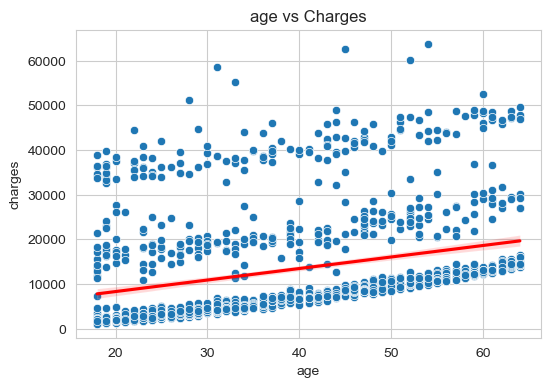

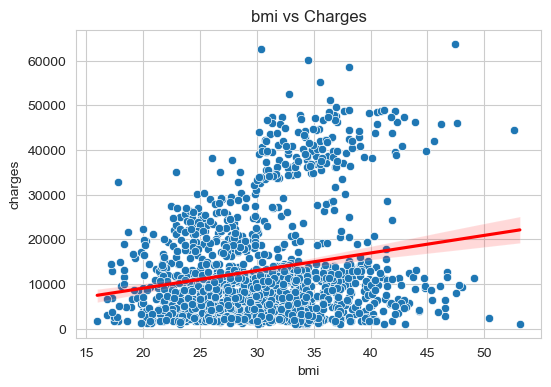

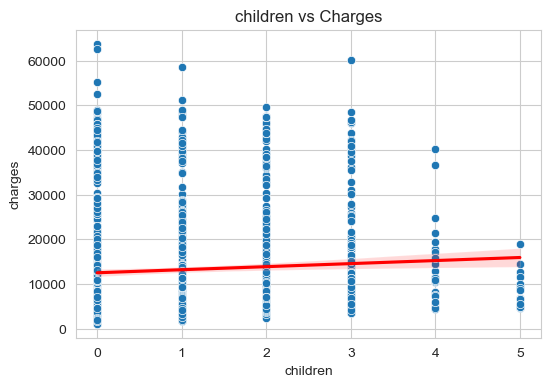

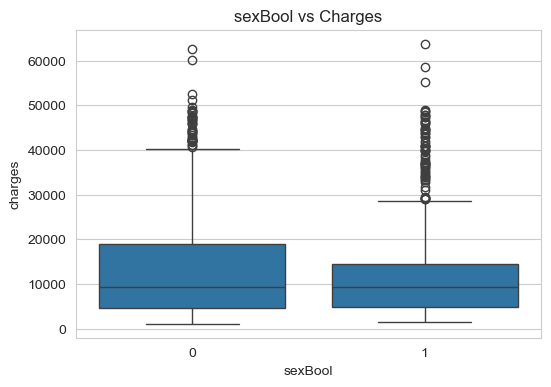

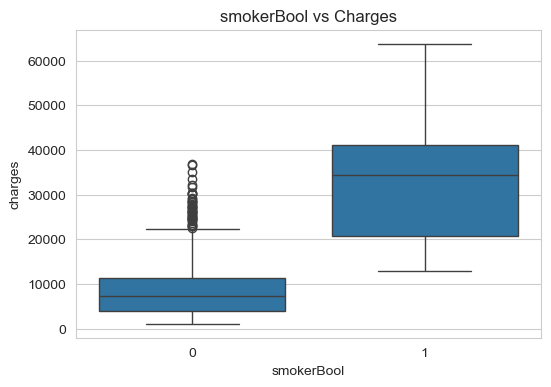

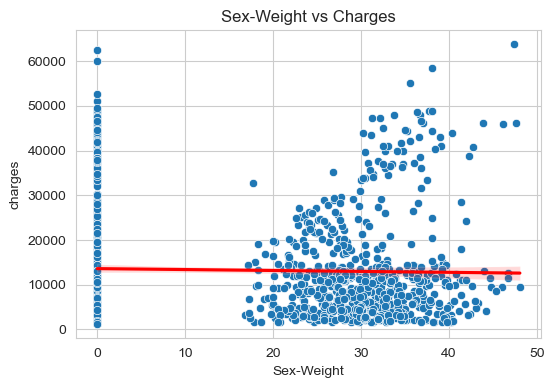

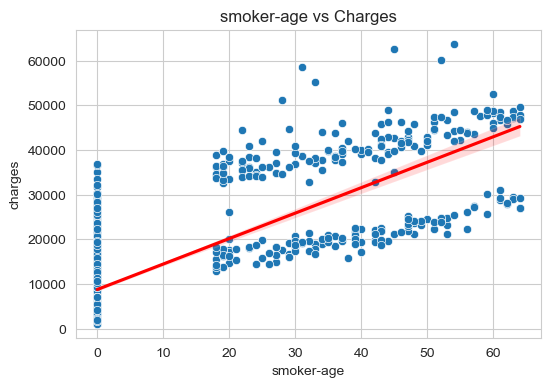

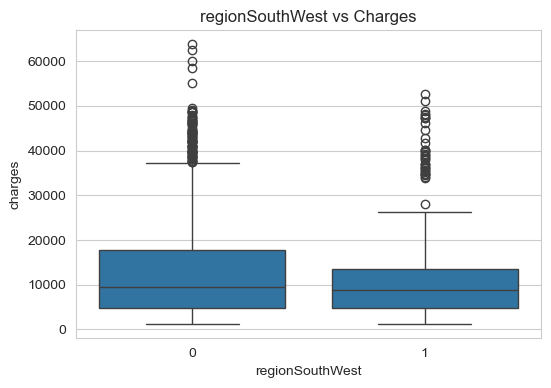

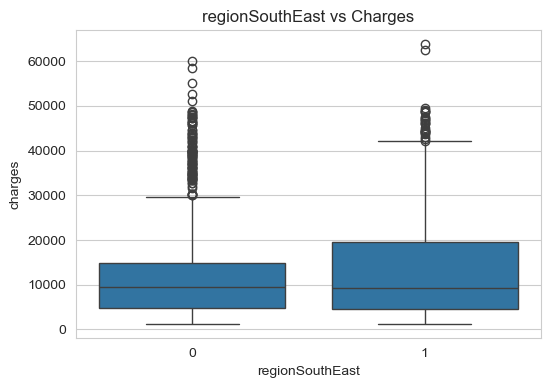

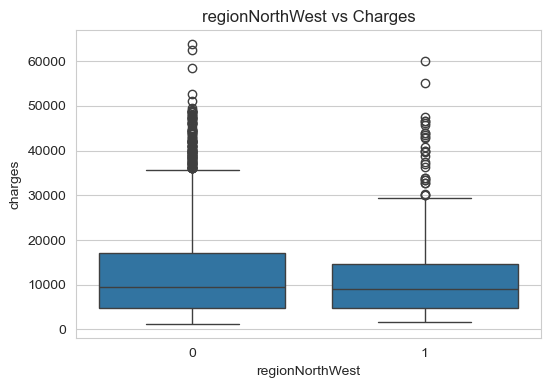

In [30]:
#My plots were ugly so I used AI to clean them up
for feature in feature_col:
    plt.figure(figsize=(6,4))
    if df[feature].nunique() <= 5:  # categorical/binary
        sns.boxplot(x=feature, y='charges', data=df)
    else:  # continuous
        sns.scatterplot(x=feature, y='charges', data=df)
        sns.regplot(x=feature, y='charges', data=df, scatter=False, color='red')
    plt.title(f"{feature} vs Charges")
    plt.show()

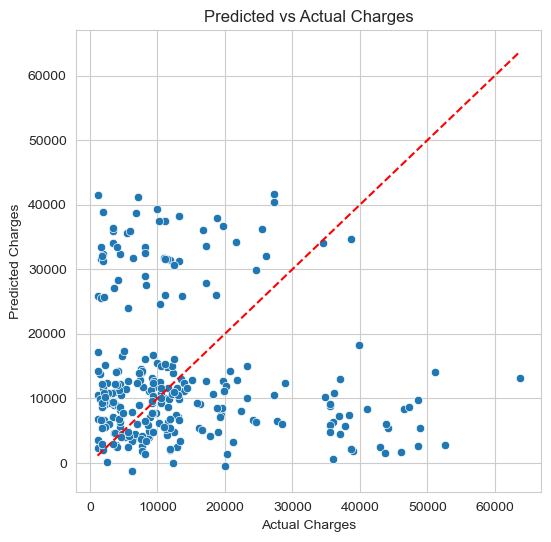

In [32]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test_multi)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges")
plt.show()

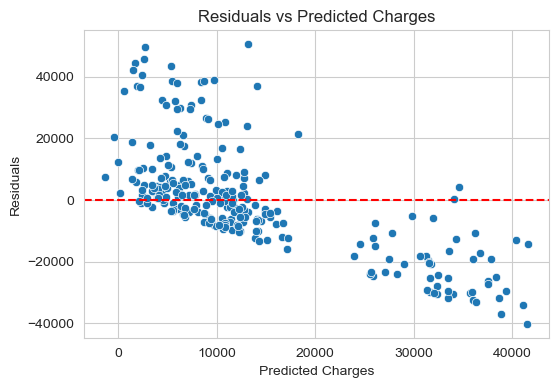

In [34]:
residuals = y_test - y_pred_test_multi
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_test_multi, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Charges")
plt.show()

In [36]:
#Displaying each features coefficient for the model
best_ridge = grid.best_estimator_
beta_scaled = best_ridge.coef_
intercept_scaled = best_ridge.intercept_
#need to unscale the model to get formula (needed help from AI because it wasn't working for me)
means = scaler.mean_
scales = scaler.scale_
beta_original = beta_scaled / scales
intercept_original = intercept_scaled - np.sum((beta_scaled * means) / scales)
for name, coef in zip(feature_col, beta_original):
    print(f"{name}: {coef:.2f}")

print("Intercept:", intercept_original)

age: 255.39
bmi: 245.00
children: 691.44
sexBool: -3304.35
smokerBool: 20207.46
Sex-Weight: 124.75
smoker-age: 60.68
regionSouthWest: -1702.89
regionSouthEast: -880.32
regionNorthWest: -482.40
Intercept: -9111.382430236796


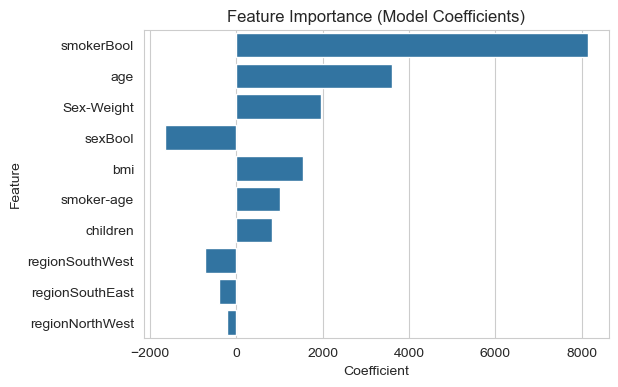

In [50]:
coef_df = pd.DataFrame({
    'Feature': feature_col,
    'Coefficient': beta_scaled
})
# Sort by absolute value
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(6,4))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title("Feature Importance (Model Coefficients)")
plt.show()

The formula for this model is Charge = 255.39*age + 245.00*BMI + 691.44*children# - 3304.35*isFemale + 20207.46*isSmoker + 124.75*womenBMI + 60.68*smokerage -1702.89*southwest - 880.32*southeast - 482.40*northwest - -9111.38

The sexBool means women get charged less
the womenBMI just means that women get charged more than men as the BMI increases.

The region means that north east is the most expensive region followed by northwest, southeast, then southwest is the cheapest.

In [ ]:
Tree Based Model

In [16]:
df = pd.read_csv("insurance.csv")

# Get basic statistics about the dataset
print("Dataset shape:", df.shape)
print("\nColumn data types:")
print(df.dtypes)

print("\nBasic statistics for numeric columns:")
print(df.describe())


Dataset shape: (1338, 7)

Column data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Basic statistics for numeric columns:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


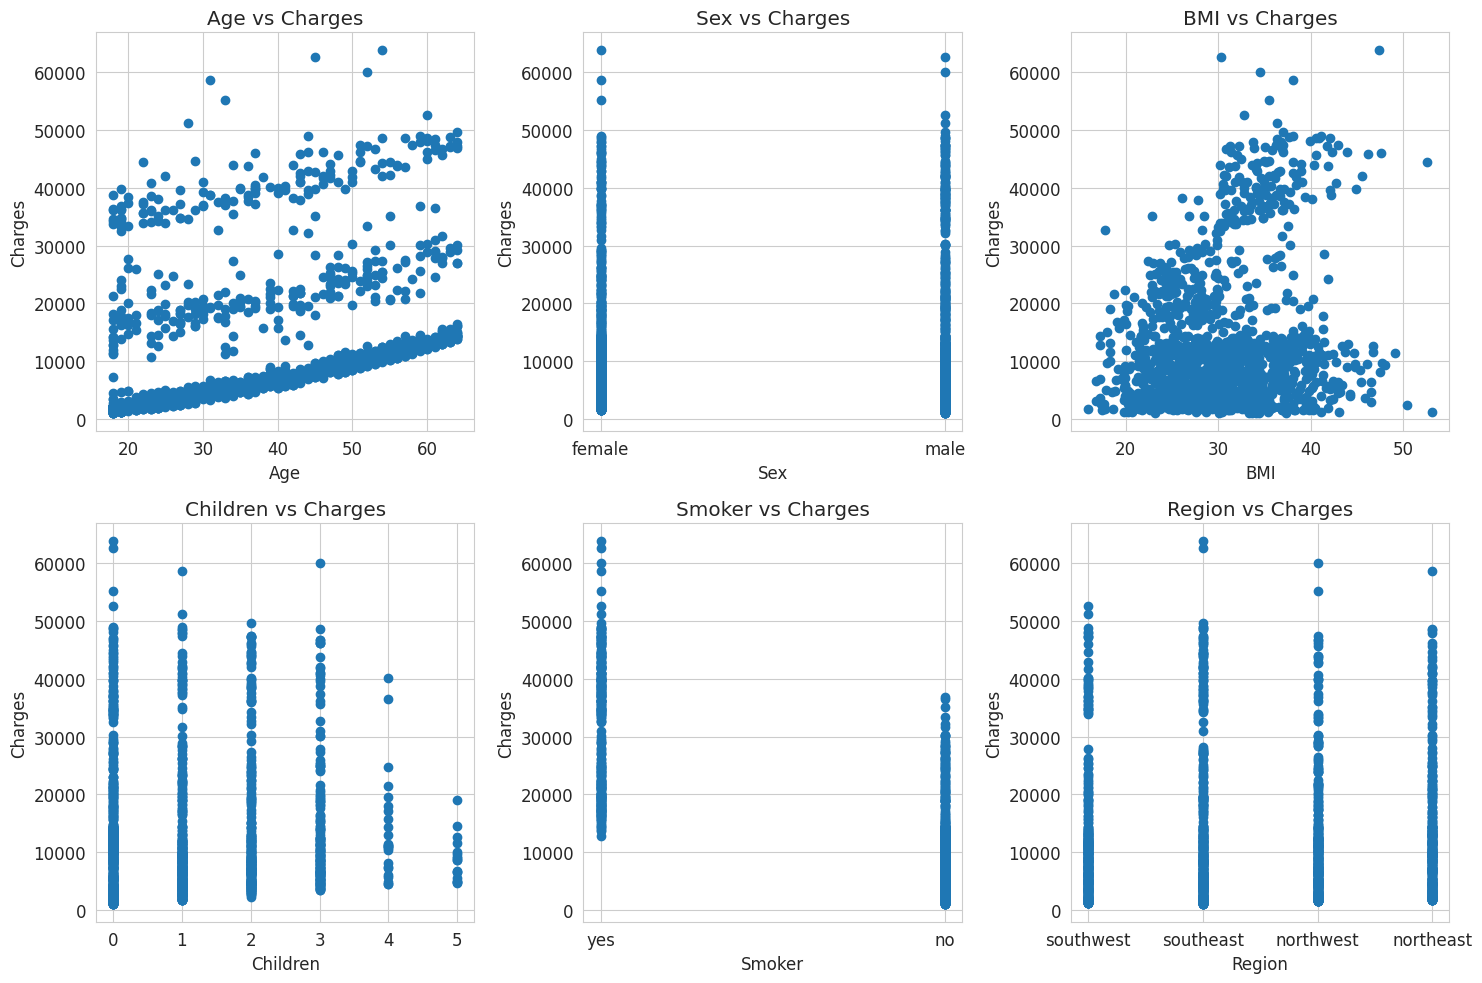

In [17]:
#Exploratory Data Analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#Plot 1: age vs charges
axes[0,0].scatter(df['age'], df['charges'])
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Charges')
axes[0,0].set_title('Age vs Charges')

#Plot 2: sex vs charges
axes[0,1].scatter(df['sex'], df['charges'])
axes[0,1].set_xlabel('Sex')
axes[0,1].set_ylabel('Charges')
axes[0,1].set_title('Sex vs Charges')

#Plot 3: bmi vs charges
axes[0,2].scatter(df['bmi'], df['charges'])
axes[0,2].set_xlabel('BMI')
axes[0,2].set_ylabel('Charges')
axes[0,2].set_title('BMI vs Charges')

#Plot 4: children vs charges
axes[1,0].scatter(df['children'], df['charges'])
axes[1,0].set_xlabel('Children')
axes[1,0].set_ylabel('Charges')
axes[1,0].set_title('Children vs Charges')

#Plot 5: smoker vs charges
axes[1,1].scatter(df['smoker'], df['charges'])
axes[1,1].set_xlabel('Smoker')
axes[1,1].set_ylabel('Charges')
axes[1,1].set_title('Smoker vs Charges')

#Plot 6: region vs charges
axes[1,2].scatter(df['region'], df['charges'])
axes[1,2].set_xlabel('Region')
axes[1,2].set_ylabel('Charges')
axes[1,2].set_title('Region vs Charges')

plt.tight_layout()
plt.show()

In [18]:
# ============================================================
# Check for missing values — ALWAYS your first step
# ============================================================
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_summary = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)

print("Columns with missing values:")
print("=" * 50)
print(missing_summary[missing_summary['Missing Count'] > 0].to_string())
print(f"\nTotal: {(missing > 0).sum()} columns have missing data")
print(f"Total missing cells: {df.isnull().sum().sum()} "
      f"out of {df.shape[0] * df.shape[1]} ({df.isnull().sum().sum() / (df.shape[0]*df.shape[1]) * 100:.1f}%)")

Columns with missing values:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

Total: 0 columns have missing data
Total missing cells: 0 out of 9366 (0.0%)


In [19]:
X = df.drop('charges', axis=1)
y = df['charges']

categorical_cols = ["sex","smoker","region"]
numeric_cols = ["age","bmi","children"]

In [20]:
# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_cols),
        ('num', "passthrough", numeric_cols)
    ]
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} clients")
print(f"Test set: {len(X_test)} clients")
print(f"\nCategorical Features: {categorical_cols}")
print(f"Numeric Features: {numeric_cols}")

Training set: 1070 clients
Test set: 268 clients

Categorical Features: ['sex', 'smoker', 'region']
Numeric Features: ['age', 'bmi', 'children']


In [21]:
# Build decision tree
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

dt_pipeline.fit(X_train, y_train)

y_pred_dt = dt_pipeline.predict(X_test)

# Evaluate
train_acc = dt_pipeline.score(X_train, y_train)
test_acc = dt_pipeline.score(X_test, y_test)
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)

print(f"Training Accuracy: {train_acc:.3f} ({train_acc*100:.1f}%)")
print(f"Test Accuracy: {test_acc:.3f} ({test_acc*100:.1f}%)")
print(f"r2 score: {r2_dt:.3f}")
print(f"MAE: {mae_dt:.3f}")

Training Accuracy: 0.998 (99.8%)
Test Accuracy: 0.727 (72.7%)
r2 score: 0.727
MAE: 3195.110


In [22]:
# Cross Validation
cv_scores = cross_val_score(
    dt_pipeline, X_train, y_train,
    cv=5,
    scoring='r2'
)
print(f"Baseline Cross-Validation RMSE: {cv_scores.mean():.3f}")

Baseline Cross-Validation RMSE: 0.678


In [23]:
# Hyperparameter Tuning
depth_values = [None, 1, 2, 3, 4, 5, 10, 20, 30]

best_depth = None
best_r2 = float(0)
best_mae = float('inf')

depth_results = {}

for depth in depth_values:
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("model", DecisionTreeRegressor(max_depth=depth, random_state=42))
    ])

    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='r2'
    )

    mean_r2 = cv_scores.mean()
    depth_results[depth] = mean_r2

    print(f"Depth: {depth}, Mean R2: {mean_r2:.3f}")

    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_depth = depth

print("\nBest Depth: ", best_depth)
print(f"Best R2: {best_r2:.3f}")

Depth: None, Mean R2: 0.678
Depth: 1, Mean R2: 0.603
Depth: 2, Mean R2: 0.819
Depth: 3, Mean R2: 0.836
Depth: 4, Mean R2: 0.837
Depth: 5, Mean R2: 0.821
Depth: 10, Mean R2: 0.715
Depth: 20, Mean R2: 0.678
Depth: 30, Mean R2: 0.678

Best Depth:  4
Best R2: 0.837


In [24]:
# Build Model with best depth
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeRegressor(max_depth=best_depth, random_state=42))
])

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.3}")


Test Set Metrics:
RMSE: 4592.76
MAE: 2697.77
R2 Score: 0.864


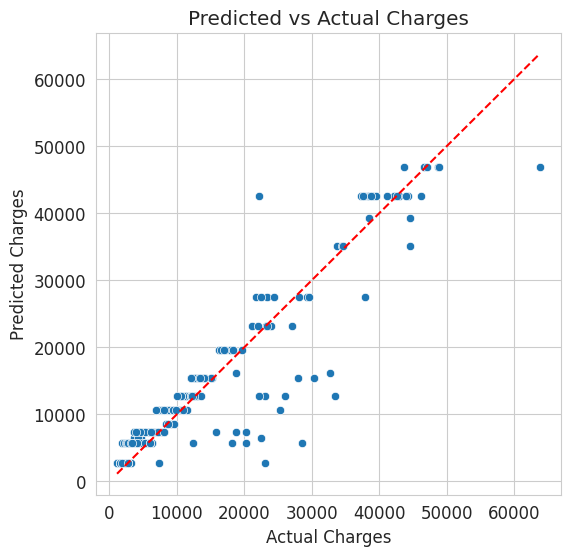

In [25]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges")
plt.show()

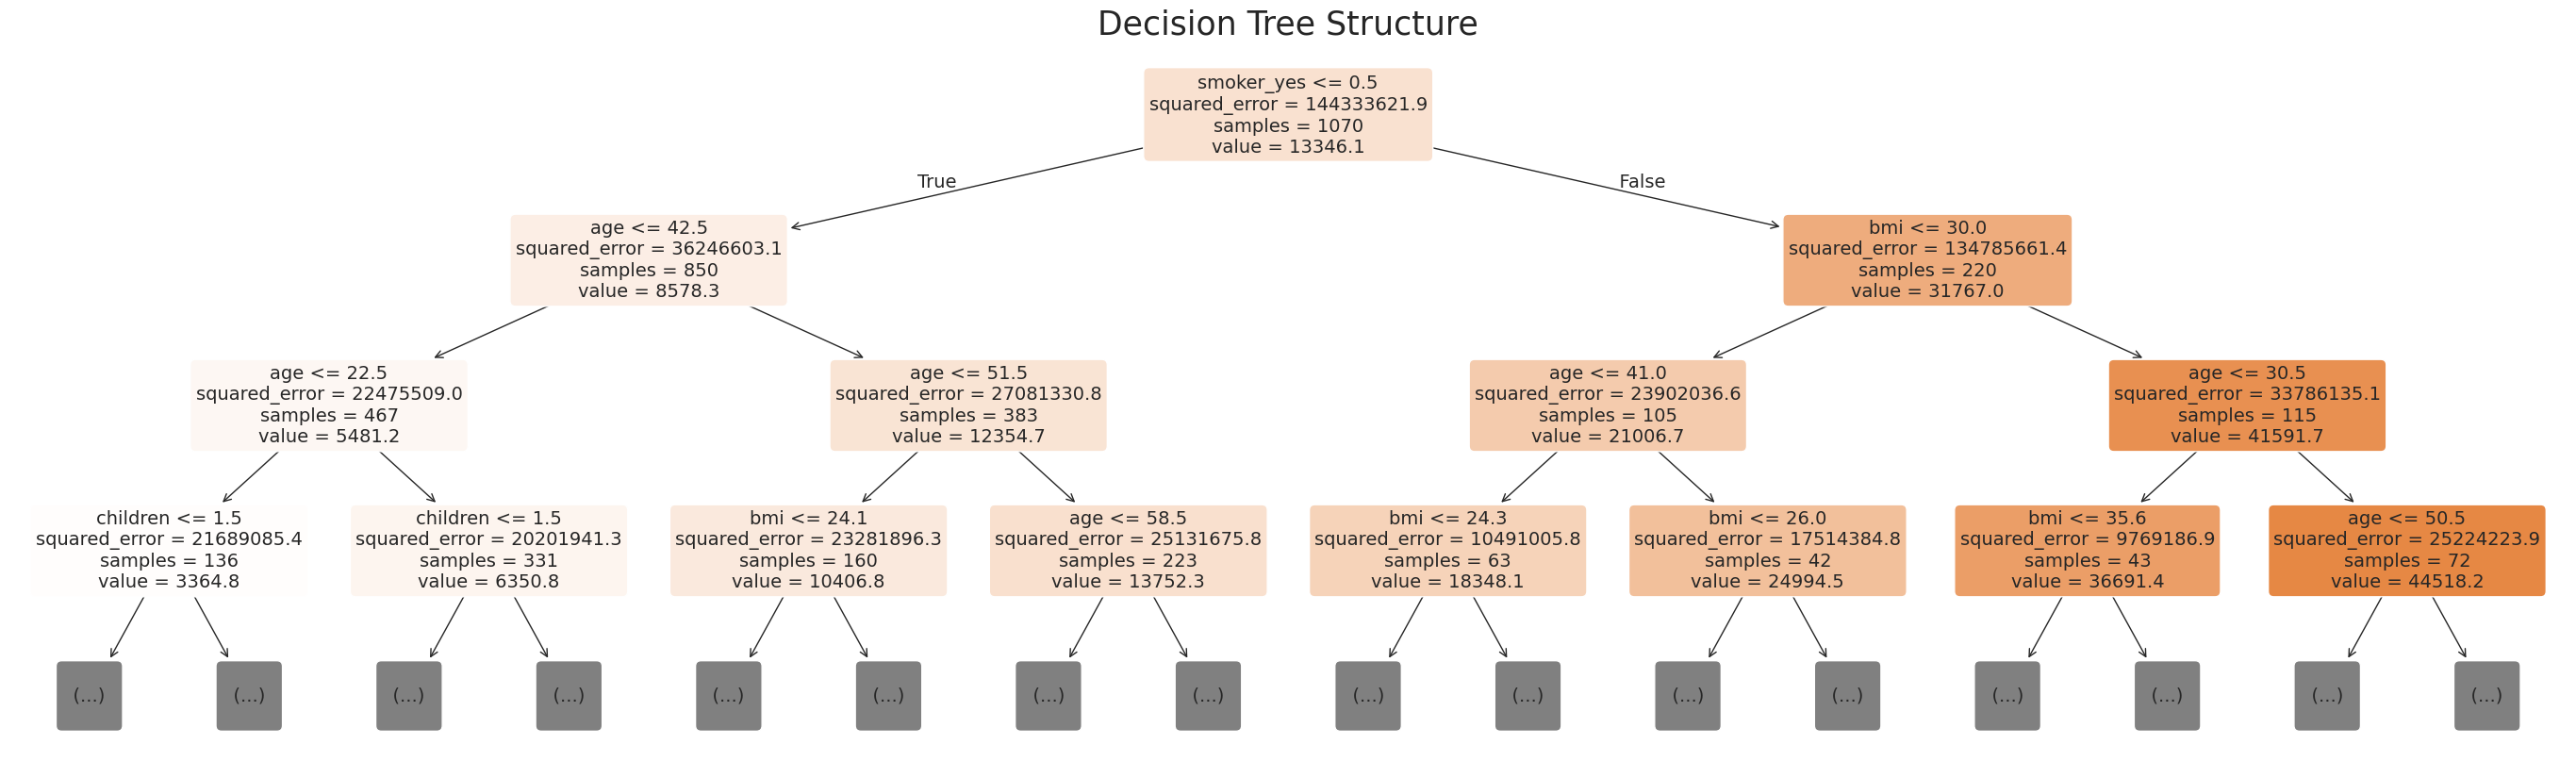

In [49]:
# Extract trained decion tree
tree_model = final_model.named_steps['model']

# Get feature names after preprocessing
ohe = final_model.named_steps['preprocessor'] \
                 .named_transformers_['cat']

encoded_cat_features = ohe.get_feature_names_out(categorical_cols)

all_feature_names = list(encoded_cat_features) + numeric_cols

# Visualizing full decision tree
plt.figure(figsize=(35,10))

plot_tree(
    tree_model,
    feature_names=all_feature_names,
    filled=True,
    rounded=True,
    fontsize=14,
    max_depth=3,
    precision=1
)

plt.title("Decision Tree Structure", fontsize=25)
plt.show()


Feature Importance:
            Feature  Importance
1        smoker_yes    0.703212
6               bmi    0.178707
5               age    0.114492
7          children    0.003589
3  region_southeast    0.000000
2  region_northwest    0.000000
0          sex_male    0.000000
4  region_southwest    0.000000


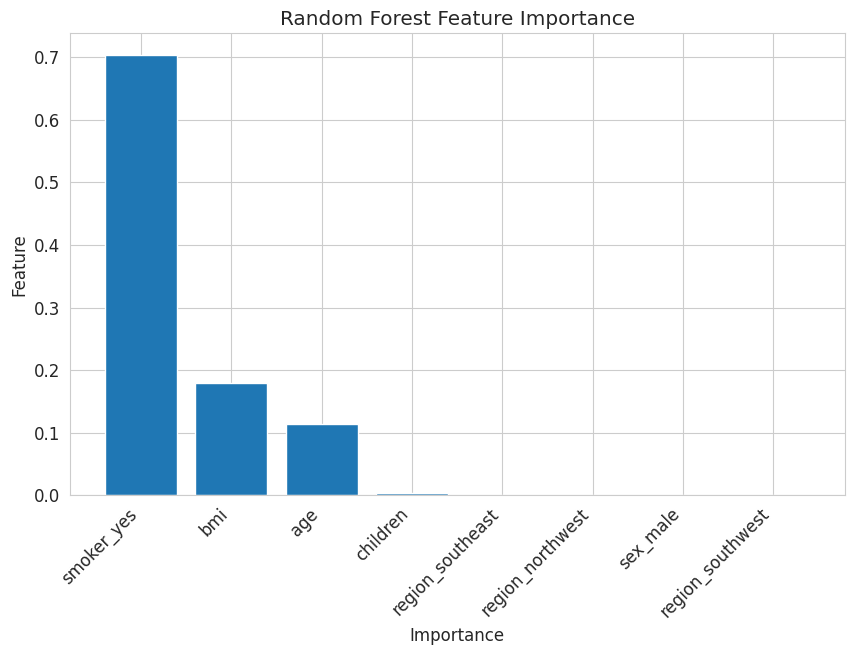

In [42]:
# Feature Importance
importances = tree_model.feature_importances_

# Sort features
importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Plot feature importance
plt.figure()
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
Random Forest Model

In [4]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
#Prepare the data for model training. Splitting the data into features (X) and the target variable (y).
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

y = df['charges']
X = df.drop('charges', axis=1)

print("Features (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())

Features (X) head:
   age     bmi  children  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0     False        True             False   
1   18  33.770         1      True       False             False   
2   28  33.000         3      True       False             False   
3   33  22.705         0      True       False              True   
4   32  28.880         0      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  

Target (y) head:
0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

print("Random Forest Regressor model trained successfully.")

Random Forest Regressor model trained successfully.


In [8]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

R-squared score: 0.8651
Mean Absolute Error (MAE): 2550.08


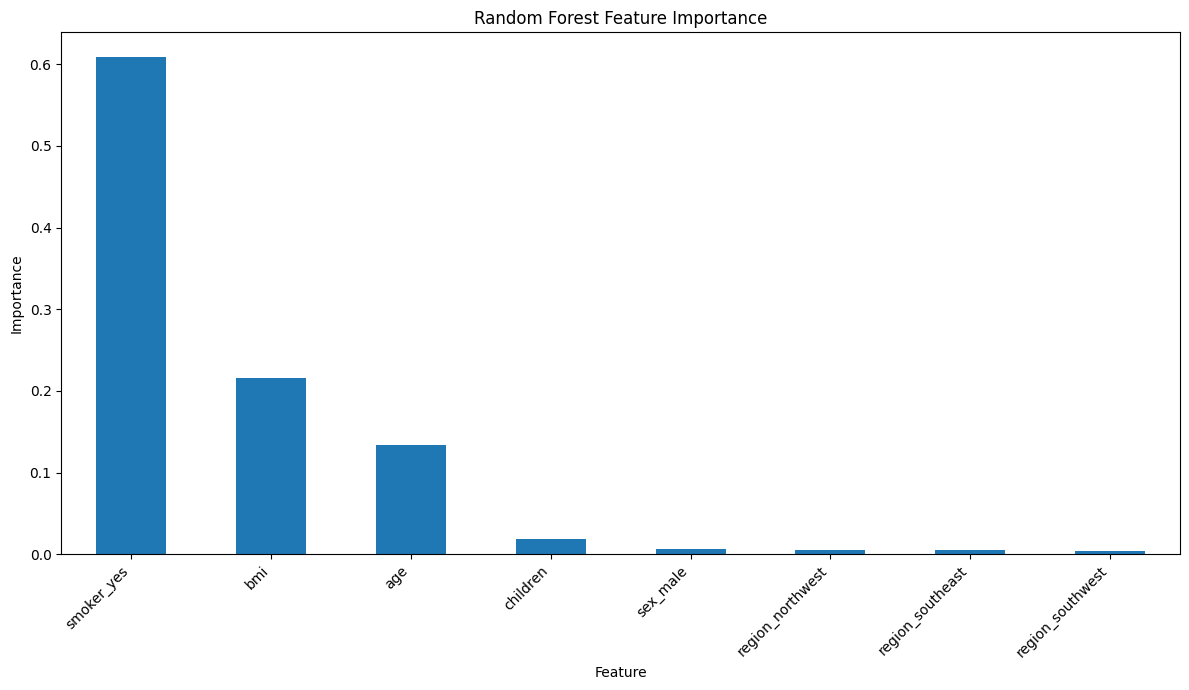

In [9]:
#plot showing most important features
# Extract feature importances
feature_importances = model.feature_importances_

# Create a Series with feature names and importances
features_df = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 7))
features_df.plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# Perform hyperparameter tuning for the Random Forest Regressor using GridSearchCV
# 2. Define a dictionary named `param_grid` specifying the hyperparameters to tune.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [1.0, 'sqrt'], # 'auto' is deprecated, use 1.0 instead for max_features=n_features
    'min_samples_leaf': [1, 2, 4]
}

# 3. Instantiate a `RandomForestRegressor` model with `random_state=42`.
rf_model = RandomForestRegressor(random_state=42)

# 4. Instantiate `GridSearchCV` with the `RandomForestRegressor` model, the `param_grid`, and appropriate cross-validation settings.
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# 5. Fit `grid_search` to the training data (`X_train`, `y_train`).
grid_search.fit(X_train, y_train)

# 6. Print the best parameters found by `GridSearchCV`.
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'max_features': 1.0, 'min_samples_leaf': 4, 'n_estimators': 200}


In [11]:
# Train a new Random Forest Regressor model using the best hyperparameters
best_params = grid_search.best_params_

# Instantiate a new RandomForestRegressor model with the best parameters
tuned_model = RandomForestRegressor(random_state=42, **best_params)

# Train this new model on the full training data
tuned_model.fit(X_train, y_train)

print("Random Forest Regressor model re-trained successfully with tuned hyperparameters.")

Random Forest Regressor model re-trained successfully with tuned hyperparameters.


In [12]:
# Make predictions on the test set using the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Calculate R-squared score for the tuned model
r2_tuned = r2_score(y_test, y_pred_tuned)

# Calculate Mean Absolute Error (MAE) for the tuned model
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"Tuned Model R-squared score: {r2_tuned:.4f}")
print(f"Tuned Model Mean Absolute Error (MAE): {mae_tuned:.2f}")
print("\n--- Comparison with untuned model ---")
print(f"Untuned Model R-squared score: {r2:.4f}")
print(f"Untuned Model Mean Absolute Error (MAE): {mae:.2f}")

Tuned Model R-squared score: 0.8775
Tuned Model Mean Absolute Error (MAE): 2468.15

--- Comparison with untuned model ---
Untuned Model R-squared score: 0.8651
Untuned Model Mean Absolute Error (MAE): 2550.08


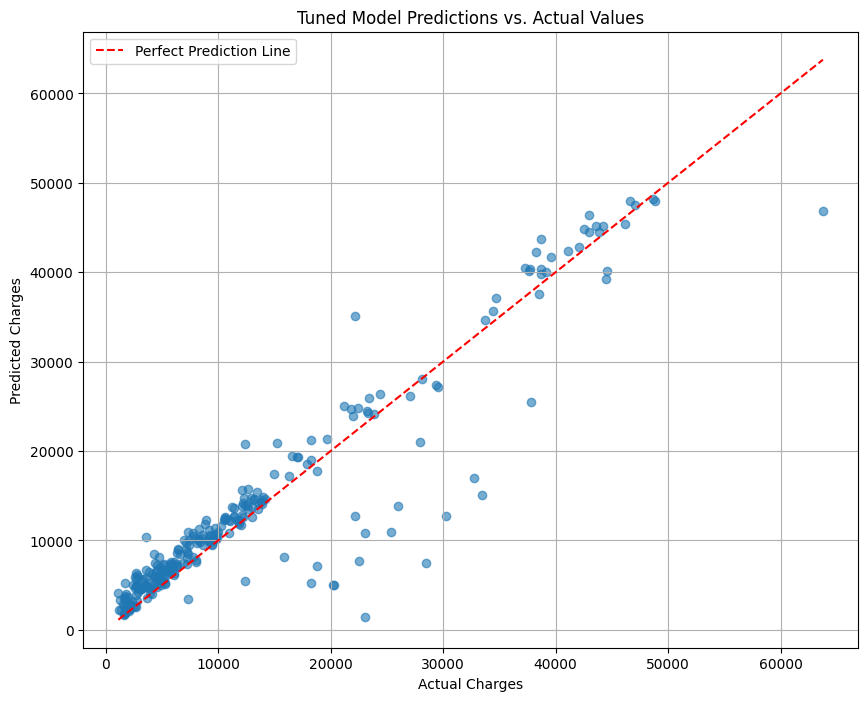

In [13]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_tuned, alpha=0.6)

# Add a diagonal line for perfect predictions
min_val = min(y_test.min(), y_pred_tuned.min())
max_val = max(y_test.max(), y_pred_tuned.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction Line')

# Add title and labels
plt.title('Tuned Model Predictions vs. Actual Values')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Bootstrap confidence intervals
def calculate_metrics(y_true, y_pred):
    """Calculates R-squared and Mean Absolute Error."""
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mae

print("Metric calculation function defined.")


Metric calculation function defined.


In [15]:
n_iterations = 2000 # Number of bootstrap samples
r2_scores_boot = []
mae_scores_boot = []

# Get indices of the test set
test_indices = np.arange(len(X_test))

for i in range(n_iterations):
    # a. Randomly sample indices with replacement from the test set's indices
    boot_indices = np.random.choice(test_indices, size=len(test_indices), replace=True)

    # b. Use these sampled indices to create bootstrap samples of X_test and y_test
    X_boot = X_test.iloc[boot_indices]
    y_boot = y_test.iloc[boot_indices]

    # c. Make predictions on X_boot using the tuned_model
    y_pred_boot = tuned_model.predict(X_boot)

    # d. Calculate the R-squared and MAE for y_boot and y_pred_boot
    r2_boot, mae_boot = calculate_metrics(y_boot, y_pred_boot)

    # e. Append these calculated R-squared and MAE values to their respective lists
    r2_scores_boot.append(r2_boot)
    mae_scores_boot.append(mae_boot)

# 5. Calculate the 2.5th and 97.5th percentiles for both bootstrapped metrics
r2_lower = np.percentile(r2_scores_boot, 2.5)
r2_upper = np.percentile(r2_scores_boot, 97.5)

mae_lower = np.percentile(mae_scores_boot, 2.5)
mae_upper = np.percentile(mae_scores_boot, 97.5)

# 6. Print the calculated 95% confidence intervals
print(f"\n95% Confidence Interval for R-squared: [{r2_lower:.4f}, {r2_upper:.4f}]")
print(f"95% Confidence Interval for MAE: [{mae_lower:.2f}, {mae_upper:.2f}]")


95% Confidence Interval for R-squared: [0.8201, 0.9217]
95% Confidence Interval for MAE: [2060.00, 2893.64]


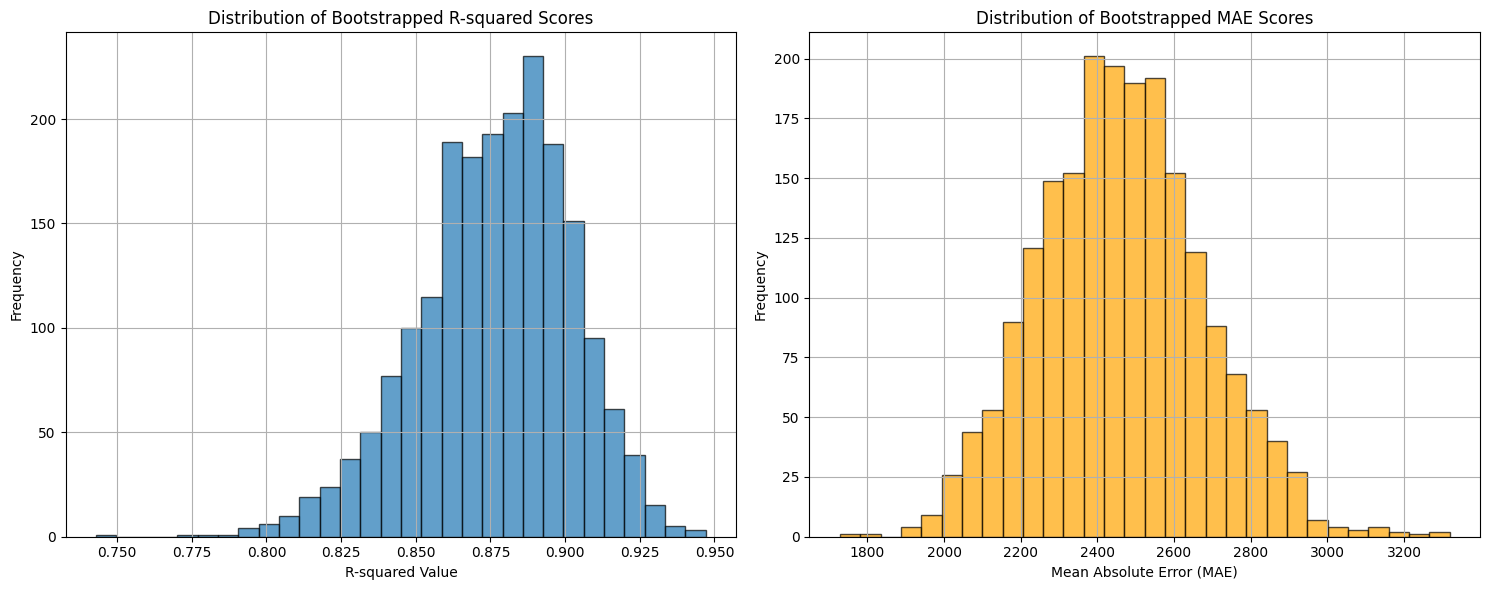

In [16]:
# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for R-squared scores
axes[0].hist(r2_scores_boot, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Bootstrapped R-squared Scores')
axes[0].set_xlabel('R-squared Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Histogram for MAE scores
axes[1].hist(mae_scores_boot, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribution of Bootstrapped MAE Scores')
axes[1].set_xlabel('Mean Absolute Error (MAE)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
Neural Network Model

In [40]:
df = pd.read_csv('insurance_cleaned.csv')

print('Dataset shape:', df.shape)
df.head()

Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [41]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing (%)': missing_pct.round(2)
})

print('Missing value summary:')
print(missing_df)

if missing.sum() == 0:
    print('\nNo missing values found')
else:
    print('\nMissing values detected')

Missing value summary:
          Missing Count  Missing (%)
age                   0          0.0
sex                   0          0.0
bmi                   0          0.0
children              0          0.0
smoker                0          0.0
region                0          0.0
charges               0          0.0

No missing values found


In [42]:
print('Data types:')
print(df.dtypes)
print()
print('Summary statistics:')
df.describe(include='all')

Data types:
age           int64
sex             str
bmi         float64
children      int64
smoker          str
region          str
charges     float64
dtype: object

Summary statistics:


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [43]:
df_clean = df.copy()

# Binary encoding for sex and smoker
df_clean['sex']    = df_clean['sex'].map({'male': 1, 'female': 0})
df_clean['smoker'] = df_clean['smoker'].map({'yes': 1, 'no': 0})

# encoding for region
df_clean = pd.get_dummies(df_clean, columns=['region'], drop_first=True)

print('Columns after encoding:')
print(df_clean.columns.tolist())
df_clean.head()

Columns after encoding:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


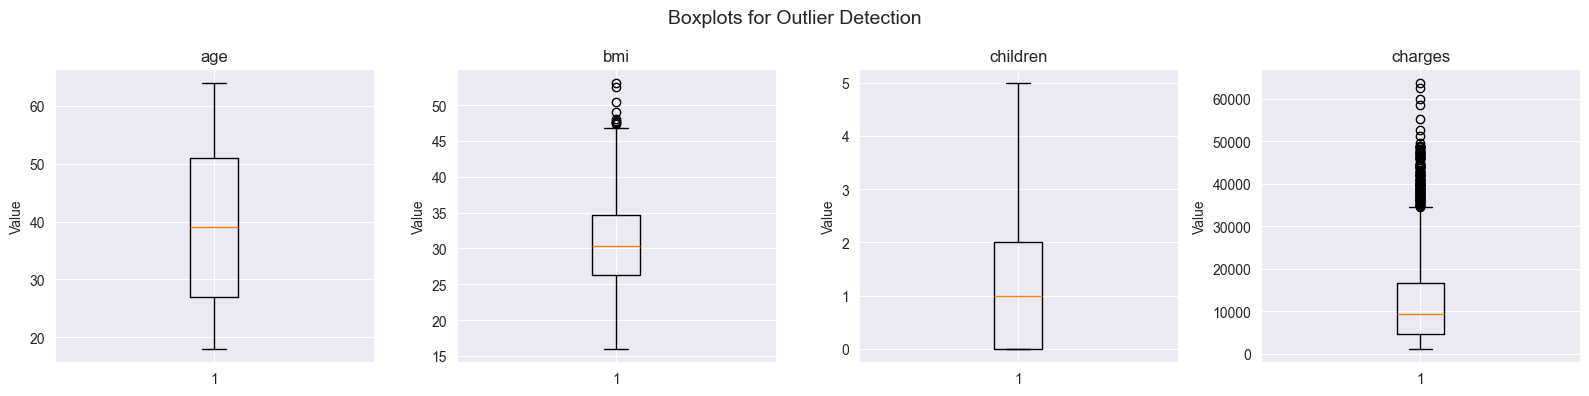

outlier counts:
  age: 0 outliers (bounds: [-9.00, 87.00])
  bmi: 9 outliers (bounds: [13.70, 47.29])
  children: 0 outliers (bounds: [-3.00, 5.00])
  charges: 139 outliers (bounds: [-13109.15, 34489.35])


In [44]:
numeric_cols = ['age', 'bmi', 'children', 'charges']

fig, axes = plt.subplots(1, len(numeric_cols), figsize=(16, 4))
fig.suptitle('Boxplots for Outlier Detection', fontsize=14)

for ax, col in zip(axes, numeric_cols):
    ax.boxplot(df_clean[col], vert=True)
    ax.set_title(col)
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# outlier counts
print('outlier counts:')
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    n_out = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
    print(f'  {col}: {n_out} outliers (bounds: [{lower:.2f}, {upper:.2f}])')

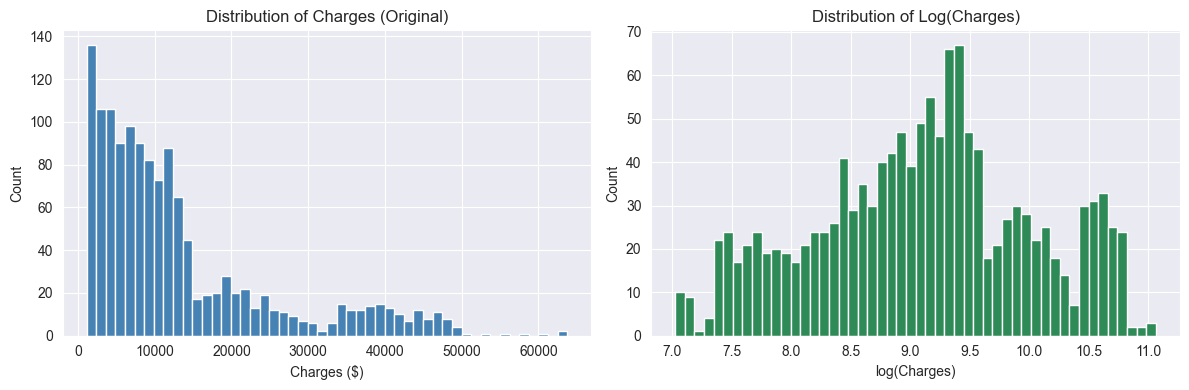

Skewness (original charges): 1.516
Skewness (log charges): -0.09


In [45]:
df_clean['log_charges'] = np.log1p(df_clean['charges'])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_clean['charges'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Distribution of Charges (Original)')
axes[0].set_xlabel('Charges ($)')
axes[0].set_ylabel('Count')

axes[1].hist(df_clean['log_charges'], bins=50, color='seagreen', edgecolor='white')
axes[1].set_title('Distribution of Log(Charges)')
axes[1].set_xlabel('log(Charges)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print('Skewness (original charges):', round(df_clean['charges'].skew(), 3))
print('Skewness (log charges):',      round(df_clean['log_charges'].skew(), 3))

In [46]:
print(f'Final cleaned dataset shape: {df_clean.shape}')
print(f'No. of features (excl. targets): {df_clean.shape[1] - 2}')
print('\nColumn list:')
print(df_clean.columns.tolist())
#df_clean.to_csv('insurance_cleaned.csv', index=False)

Final cleaned dataset shape: (1338, 10)
No. of features (excl. targets): 8

Column list:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest', 'log_charges']


model

In [47]:

df = pd.read_csv('insurance_cleaned.csv')

feature_cols = [c for c in df.columns if c not in ['charges', 'log_charges']]
X = df[feature_cols].values
y_log = df['log_charges'].values    # log-transformed
y_raw = df['charges'].values        # original dollar scale


X_train, X_temp, y_train, y_temp, y_raw_train, y_raw_temp = train_test_split(
    X, y_log, y_raw, test_size=0.20, random_state=42
)
X_val, X_test, y_val, y_test, y_raw_val, y_raw_test = train_test_split(
    X_temp, y_temp, y_raw_temp, test_size=0.50, random_state=42
)

print(f'Features:       {len(feature_cols)} → {feature_cols}')
print(f'Training set:   {X_train.shape[0]} samples')
print(f'Validation set: {X_val.shape[0]} samples')
print(f'Test set:       {X_test.shape[0]} samples')

Features:       8 → ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']
Training set:   1069 samples
Validation set: 134 samples
Test set:       134 samples


In [48]:

nn_unscaled = MLPRegressor(hidden_layer_sizes=(256), max_iter=500, random_state=42)
nn_unscaled.fit(X_train, y_train)
r2_unscaled = r2_score(y_val, nn_unscaled.predict(X_val))

nn_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor(hidden_layer_sizes=(256), max_iter=500, random_state=42))
])
nn_scaled.fit(X_train, y_train)
r2_scaled = r2_score(y_val, nn_scaled.predict(X_val))

print(f'R² WITHOUT scaling: {r2_unscaled:.4f}')
print(f'R² WITH scaling:    {r2_scaled:.4f}')

R² WITHOUT scaling: 0.7818
R² WITH scaling:    0.8561


In [49]:
architectures = {
    'Small (32)':           (32,),
    'Medium (64, 32)':      (64, 32),
    'Large (128, 64, 32)':  (128, 64, 32),
    'Wide (256)':           (256,),
}

arch_results = {}
print('Architecture Comparison — 5-Fold CV on Training Set (R²)')
print('=' * 60)

for name, layers in architectures.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('nn', MLPRegressor(
            hidden_layer_sizes=layers,
            activation='relu',
            max_iter=500,
            random_state=42
        ))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
    arch_results[name] = scores
    # Count parameters
    pipe.fit(X_train, y_train)
    nn_model = pipe.named_steps['nn']
    n_params = sum(w.size for w in nn_model.coefs_) + sum(b.size for b in nn_model.intercepts_)
    print(f'{name:<22}  R² = {scores.mean():.4f} ± {scores.std():.4f}  ({n_params} params)')

Architecture Comparison — 5-Fold CV on Training Set (R²)
Small (32)              R² = 0.7522 ± 0.0299  (321 params)
Medium (64, 32)         R² = 0.7883 ± 0.0309  (2689 params)
Large (128, 64, 32)     R² = 0.7932 ± 0.0205  (11521 params)
Wide (256)              R² = 0.8069 ± 0.0296  (2561 params)


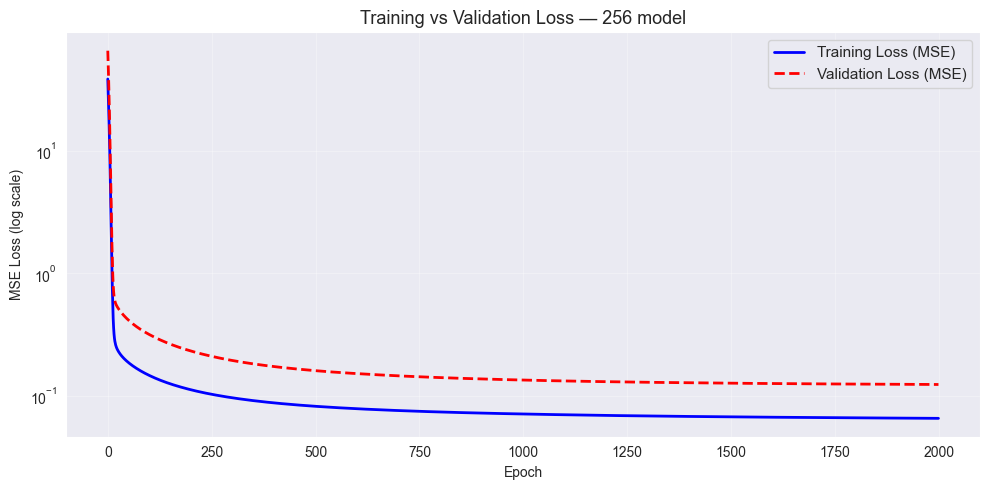

Final training loss:   0.0655
Final validation loss: 0.1238


In [50]:
scaler_check = StandardScaler()
X_train_sc = scaler_check.fit_transform(X_train)
X_val_sc   = scaler_check.transform(X_val)

nn_track = MLPRegressor(
    hidden_layer_sizes=(256),
    activation='relu',
    solver='sgd',
    max_iter=1,
    warm_start=True,
    random_state=42
)

train_losses, val_losses = [], []
n_epochs = 2000

for epoch in range(n_epochs):
    nn_track.fit(X_train_sc, y_train)
    train_losses.append(nn_track.loss_)
    val_pred = nn_track.predict(X_val_sc)
    val_losses.append(mean_squared_error(y_val, val_pred))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Training Loss (MSE)', color='blue', linewidth=2)
ax.plot(val_losses,   label='Validation Loss (MSE)', color='red', linewidth=2, linestyle='--')
ax.set_title(f'Training vs Validation Loss — {256} model', fontsize=13)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss (log scale)')
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Final training loss:   {train_losses[-1]:.4f}')
print(f'Final validation loss: {val_losses[-1]:.4f}')

In [51]:
best_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor(hidden_layer_sizes=(256), activation='relu',        #learning_rate='constant',
                        #learning_rate='invscaling',
                        learning_rate='adaptive',
        learning_rate_init=0.0005,
                          max_iter=500, random_state=42))
])
best_nn.fit(X_train, y_train)

y_pred_log = best_nn.predict(X_test)
y_pred_raw = np.expm1(y_pred_log)   # convet back from log scale

r2_log   = r2_score(y_test, y_pred_log)
mae_log  = mean_absolute_error(y_test, y_pred_log)

r2_raw   = r2_score(y_raw_test, y_pred_raw)
mae_raw  = mean_absolute_error(y_raw_test, y_pred_raw)

print(best_nn.named_steps['nn'].get_params())
print(f'Log-scale   R²:   {r2_log:.4f}')
print(f'Log-scale   MAE:  {mae_log:.4f}')
print()
print(f'Dollar-scale R²:   {r2_raw:.4f}')
print(f'Dollar-scale MAE:  ${mae_raw:,.2f}')

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 256, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005, 'loss': 'squared_error', 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Log-scale   R²:   0.8906
Log-scale   MAE:  0.1968

Dollar-scale R²:   0.8508
Dollar-scale MAE:  $2,815.56


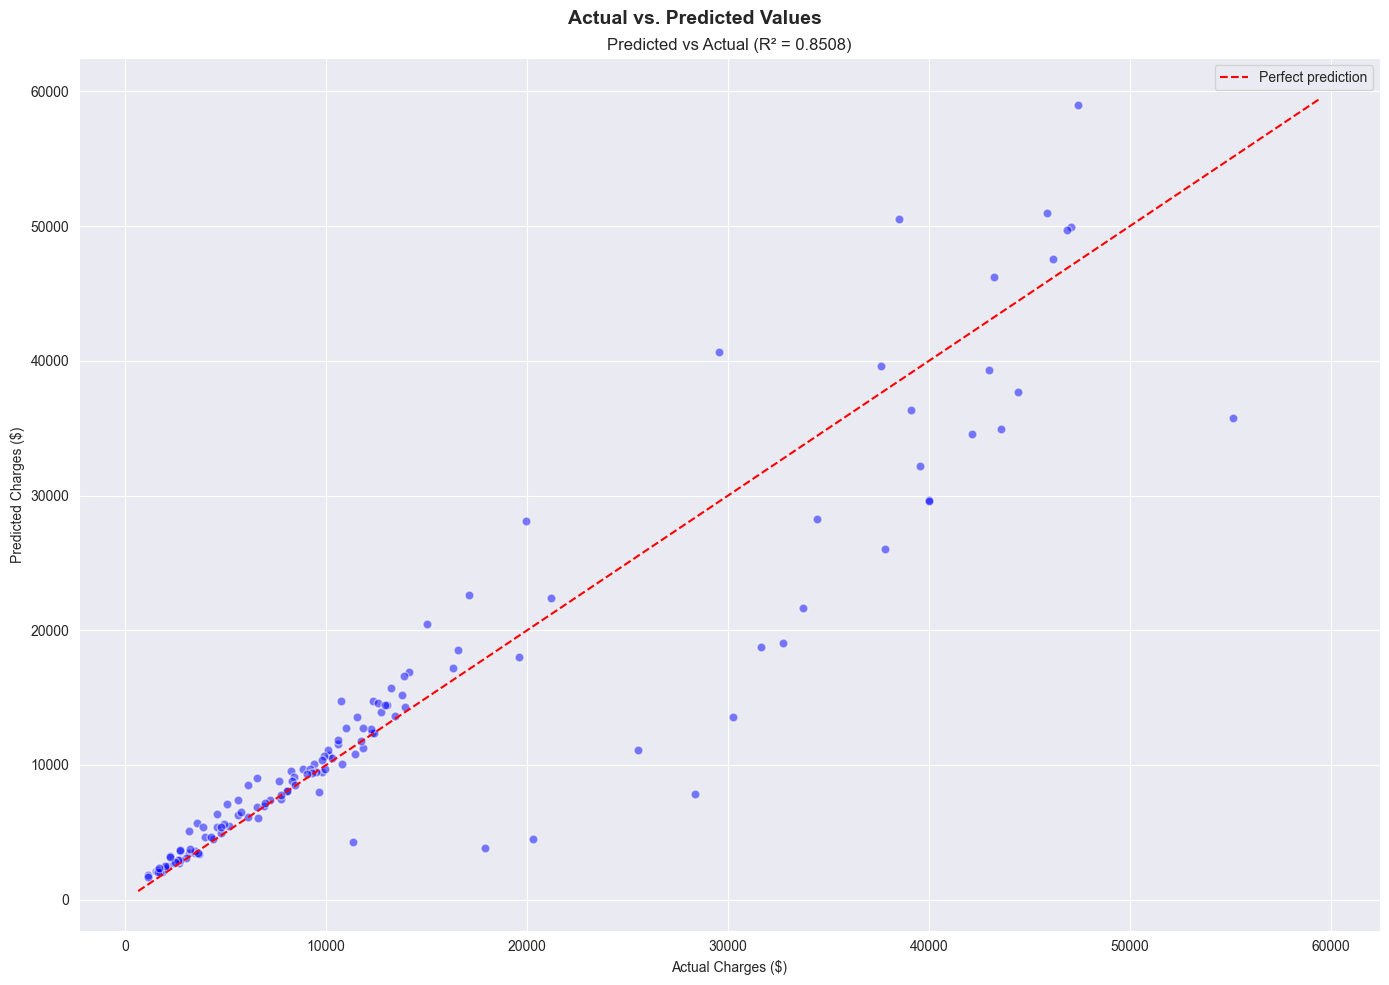

Residual mean:  $599.92
Residual std:   $5,175.72
Max error:      $20,461.82


In [52]:
residuals = y_raw_test - y_pred_raw

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
fig.suptitle('Actual vs. Predicted Values', fontsize=14, fontweight='bold')

ax.scatter(y_raw_test, y_pred_raw, alpha=0.5,
           color='blue', edgecolors='white', s=40)

lims = [min(y_raw_test.min(), y_pred_raw.min()) - 500,
        max(y_raw_test.max(), y_pred_raw.max()) + 500]

ax.plot(lims, lims, 'r--', linewidth=1.5, label='Perfect prediction')

ax.set_xlabel('Actual Charges ($)')
ax.set_ylabel('Predicted Charges ($)')
ax.set_title(f'Predicted vs Actual (R² = {r2_raw:.4f})')
ax.legend()

plt.tight_layout()
plt.show()

print(f'Residual mean:  ${residuals.mean():,.2f}')
print(f'Residual std:   ${residuals.std():,.2f}')
print(f'Max error:      ${np.abs(residuals).max():,.2f}')

feature importance

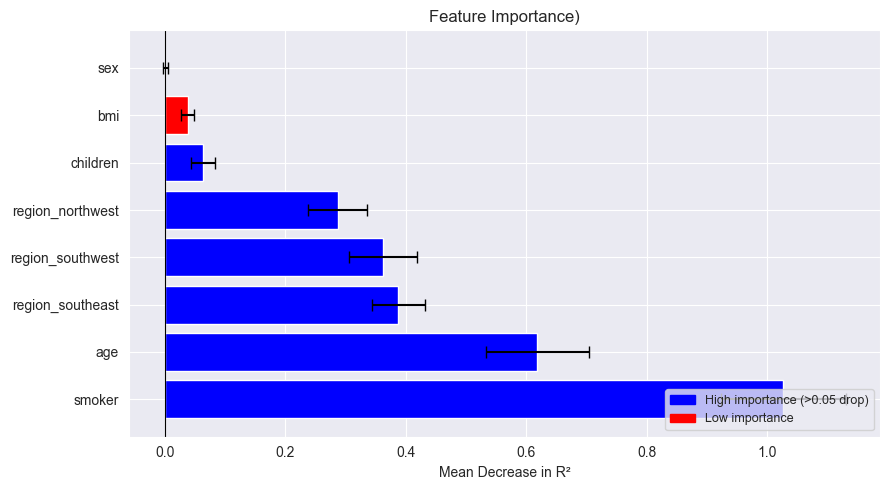


Feature Importance
---------------------------------------------
  smoker                    +1.0266 ± 0.1039
  age                       +0.6183 ± 0.0860
  region_southeast          +0.3876 ± 0.0435
  region_southwest          +0.3616 ± 0.0563
  region_northwest          +0.2868 ± 0.0486
  children                  +0.0632 ± 0.0199
  bmi                       +0.0378 ± 0.0110
  sex                       +0.0008 ± 0.0041


In [53]:
perm_result = permutation_importance(
    best_nn, X_test, y_test,
    n_repeats=30, random_state=42, scoring='r2'
)

sorted_idx = perm_result.importances_mean.argsort()[::-1]
sorted_names  = np.array(feature_cols)[sorted_idx]
sorted_means  = perm_result.importances_mean[sorted_idx]
sorted_stds   = perm_result.importances_std[sorted_idx]

fig, ax = plt.subplots(figsize=(9, 5))
colors_fi = ['blue' if m > 0.05 else 'red' for m in sorted_means]
ax.barh(sorted_names, sorted_means, xerr=sorted_stds,
        color=colors_fi, edgecolor='white', capsize=4)
ax.axvline(0, color='black', linewidth=0.8, linestyle='-')
ax.set_title('Feature Importance)',
             fontsize=12)
ax.set_xlabel('Mean Decrease in R²')

red_patch  = mpatches.Patch(color='blue', label='High importance (>0.05 drop)')
blue_patch = mpatches.Patch(color='red', label='Low importance')
ax.legend(handles=[red_patch, blue_patch], loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

print('\nFeature Importance')
print('-' * 45)
for name, mean, std in zip(sorted_names, sorted_means, sorted_stds):
    print(f'  {name:<25} {mean:+.4f} ± {std:.4f}')

Bootstrap 95% Confidence Intervals:
  R²:   [0.7797,  0.9034]   point estimate: 0.8508
  MAE:  [$2,105.41,  $3,560.78]   point estimate: $2,815.56


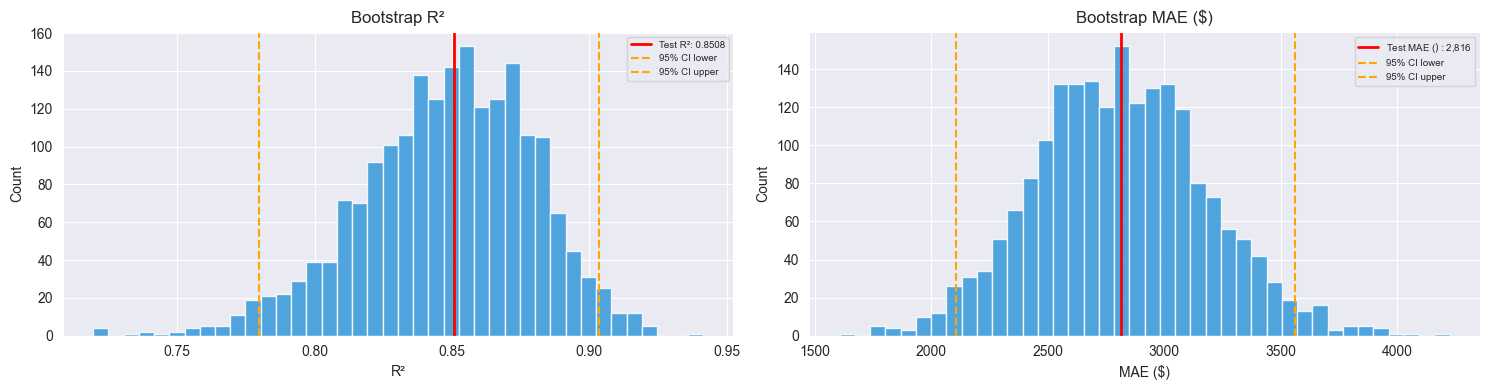

In [54]:
np.random.seed(42)
n_bootstrap = 2000
boot_r2, boot_mae = [], []

for _ in range(n_bootstrap):
    idx = np.random.choice(len(y_raw_test), size=len(y_raw_test), replace=True)
    boot_r2.append(r2_score(y_raw_test[idx], y_pred_raw[idx]))
    boot_mae.append(mean_absolute_error(y_raw_test[idx], y_pred_raw[idx]))

ci = {}
for name, data, point in [('R²', boot_r2, r2_raw),
                            ('MAE',  boot_mae,  mae_raw)]:
    lo, hi = np.percentile(data, [2.5, 97.5])
    ci[name] = (lo, hi, point)
print('Bootstrap 95% Confidence Intervals:')
print(f"  R²:   [{ci['R²'][0]:.4f},  {ci['R²'][1]:.4f}]   point estimate: {ci['R²'][2]:.4f}")
print(f"  MAE:  [${ci['MAE'][0]:,.2f},  ${ci['MAE'][1]:,.2f}]   point estimate: ${ci['MAE'][2]:,.2f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

for ax, (metric, data, point) in zip(axes, [
    ('R²', boot_r2, r2_raw),
    ('MAE ($)',  boot_mae,  mae_raw)
]):
    lo, hi = np.percentile(data, [2.5, 97.5])
    ax.hist(data, bins=40, color='#3498db', edgecolor='white', alpha=0.85)
    ax.axvline(point, color='red',    linestyle='-',  linewidth=2,   label=f'Test {metric}: {point:.4f}' if metric == 'R²' else f'Test {metric}: ${point:,.0f}')
    ax.axvline(lo,    color='orange', linestyle='--', linewidth=1.5, label=f'95% CI lower')
    ax.axvline(hi,    color='orange', linestyle='--', linewidth=1.5, label=f'95% CI upper')
    ax.set_title(f'Bootstrap {metric}')
    ax.set_xlabel(metric)
    ax.set_ylabel('Count')
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

cross vaildation

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2   = cross_val_score(best_nn, X, y_log, cv=kf, scoring='r2')
cv_rmse = np.sqrt(-cross_val_score(best_nn, X, y_log, cv=kf,
                                    scoring='neg_mean_squared_error'))
cv_mae  = -cross_val_score(best_nn, X, y_log, cv=kf,
                            scoring='neg_mean_absolute_error')

print('\n5-Fold Cross-Validation Results — Neural Network')
print('=' * 52)
print(f"{'Fold':<8} {'R²':>8} {'MAE':>10}")
print('-' * 42)
for i, (r2, mae) in enumerate(zip(cv_r2, cv_mae), 1):
    print(f"Fold {i:<4} {r2:>8.4f} {mae:>10.4f}")
print('-' * 42)
print(f"{'Mean':<8} {cv_r2.mean():>8.4f} {cv_rmse.mean():>10.4f} {cv_mae.mean():>10.4f}")
print(f"{'Std':<8} {cv_r2.std():>8.4f} {cv_rmse.std():>10.4f} {cv_mae.std():>10.4f}")


5-Fold Cross-Validation Results — Neural Network
Fold           R²        MAE
------------------------------------------
Fold 1      0.8710     0.2092
Fold 2      0.7925     0.2268
Fold 3      0.7859     0.2261
Fold 4      0.8110     0.2260
Fold 5      0.8347     0.2056
------------------------------------------
Mean       0.8190     0.3882     0.2187
Std        0.0310     0.0289     0.0093


Feature Importance & Interpretation
   Refer to the feature importance in the plots above (I cant figure out how to move selected graphs into one place).
   The smoker variable is the most important in all models.
   
Final Recommendations
Best model: Random Forest seems to be the best model. It has the best confidence intervals and R^2 values. In terms of interpretability, the linear model seems to be the most understandable and presentably, but least accurate. The Neural network Was also very good, but it needs even more data points to become better than the random forest model.

Limitations: The limitations mainly come from the data itself. In the data, it doesn't define which insurance company the individual is using, any other health conditions, or specify where each of the regions exactly are.

Uncertainties: There is a wide price range base on bootstrapping.

Deployment: Useful for insurance companies expecting new clients.

Future work: For future work, it would be nice to layer this with other data. We could search for specific insurance companies and compare them to create another layer to the model.

Conclusion
Based on the data set give, the best model of our group was the random forest tree. This makes sense as it is a direct step up from the decision tree model. It also helps that there is a lot of categorical and binary data that make up most of the importance such as the smoker variable.